In [1]:
# import
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

# load csv files
energyData = pd.read_csv('energy_data.csv')
weatherData = pd.read_csv('weather_data.csv')

In [2]:
# To add 'use [kW]' column to weatherData based on time values, the respective time columns in both
# dataframes need to be of the same type. I converted both columns to datetime64[ns] type.
# I then merged weatherData dataframe with a subset of energyData dataframe, a dataframe with 'Date & Time' and 'use [kW]'
# the redundant 'Date & Time' column in weatherData was dropped.
# Finally, I replaced any missing values in weatherData with 0 for cleaning purposes

# parse time fields to make them compatible as datetime64[ns]
# convert weatherData 'time' from unix time seconds to datetime64[ns]
weatherData['time'] = pd.to_datetime(weatherData['time'], unit='s')
# convert energyData 'Date & Time' from string to datetime64[ns]
energyData['Date & Time'] = pd.to_datetime(energyData['Date & Time'])

# append 'use [kW]' column to weatherData
# Merge the DataFrames on the common column 'time' and update the 'use [kW]' column in weatherData
weatherData = weatherData.merge(energyData[['Date & Time', 'use [kW]']], how='left', left_on='time', right_on='Date & Time')
# Drop the 'Date & Time' column from weatherData
weatherData.drop('Date & Time', axis=1, inplace=True)

# replace any missing values in weatherData with 0
weatherData.fillna(0, inplace=True)

In [3]:
# The weatherData dataframe now must be split into training and test sets. Because the prediction domain is the month of December,
# the training set will be entries from January to November and the test set will be entries from December.
# y_train and y_test will be the 'use [kW]' column in weatherData.
# "time", "icon", and "summary" columns will be dropped from the linear regression because they are not numerical values where a
# linear regresssion-relationship can be established between them and 'use [kW]'.

# split weatherData into training set and test set
# training set
x_train = weatherData[weatherData['time'].dt.month != 12].drop(['use [kW]', "time", "icon", "summary"], axis=1)
y_train = weatherData[weatherData['time'].dt.month != 12]['use [kW]']
# test set
x_test = weatherData[weatherData['time'].dt.month == 12].drop(['use [kW]', "time", "icon", "summary"], axis=1)
y_test = weatherData[weatherData['time'].dt.month == 12]['use [kW]']

In [4]:
# The linear regression model is trained on the training set and then used to predict the energy usage in the test set.
# Accuracy of the predictions is measured by RMSE: root mean squared error and printed below.
# Predictions were dumped to a csv file.

# train linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# predict
y_pred = model.predict(x_test)

# calculate root mean squared error, comparing predictions to actual values
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Root Mean Squared Error: ', rmse)

# generate csv dump of two columns, date and prediction
dec_weatherData = weatherData[weatherData['time'].dt.month == 12]
# create a DataFrame with the predicted energy usage values and corresponding dates
predictions_df = pd.DataFrame({'date': dec_weatherData['time'], 'prediction': y_pred})
# set the 'date' column as the index
predictions_df.set_index('date', inplace=True)
# save the DataFrame as a csv file
predictions_df.to_csv('cse351_hw2_yang_sungmo_112801117_linear_regression.csv')

Root Mean Squared Error:  0.41147613698790025


In [5]:
# The logistic regression model is trained on the training set and then used to predict the temperature in the test set.
# Because logistic regression is a classification model, the temperature values in the 'temperature' column of weatherData
# are converted to a binary classification of high(1) or low(0) temperature, where the threshold is 35 degrees Celsius.
# Accuracy of the predictions is measured by F1 score and printed below
# Predictions were dumped to a csv file.

# logistic regression for high or low temperature where 1 is high, 0 is low
weatherData['temperature_class'] = np.where(weatherData['temperature'] >= 35, 1, 0)

# split weatherData into training set and test set
x_train = weatherData[weatherData['time'].dt.month != 12].drop(['use [kW]', "time", "icon", "summary", "temperature_class"], axis=1)
y_train = weatherData[weatherData['time'].dt.month != 12]['temperature_class']

x_test = weatherData[weatherData['time'].dt.month == 12].drop(['use [kW]', "time", "icon", "summary", "temperature_class"], axis=1)
y_test = weatherData[weatherData['time'].dt.month == 12]['temperature_class']

# train logistic regression model
model = LogisticRegression(max_iter=300)
model.fit(x_train, y_train)

# predict
y_pred = model.predict(x_test)

# calculate accuracy F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score: ', f1)

# generate csv dump of two columns, date and prediction
dec_weatherData = weatherData[weatherData['time'].dt.month == 12]
# create a DataFrame with the predicted high or low temp (1/0) and corresponding dates
predictions_df = pd.DataFrame({'date': dec_weatherData['time'], 'prediction': y_pred})
# set the 'date' column as the index
predictions_df.set_index('date', inplace=True)
# save the DataFrame as a csv file
predictions_df.to_csv('cse351_hw2_yang_sungmo_112801117_logistic_regression.csv')

F1 Score:  0.9932771096177578


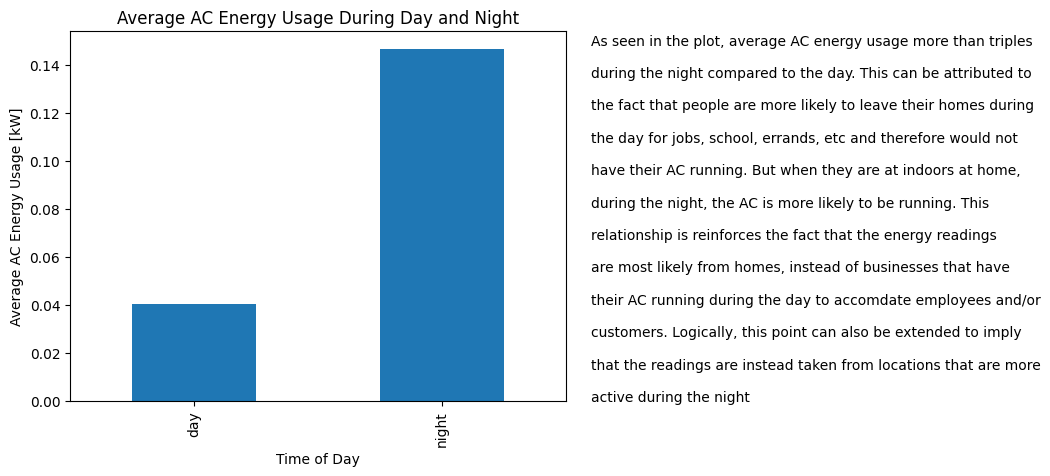

In [6]:
# energy usage data analysis
# Day: 6AM to 7 PM
# Night: 7PM to 6AM
# Analyze the usage of any two devices of your choice during the ‘day’ and ‘night’. Plot these trends. Explain your findings.
# Devices: AC, Furnance, Cellar Lights, Washer, First Floor Lights, Utility Rm + Basement Bath, Garage outlets,
# MBed + Kbed outlets, Dryer + eguage, Panel GFI, Home Office, Dining Room, Microwave, Fridge

# add a column to energyData for "day" or "night" based on time (6AM to 7PM vs 7PM to 6AM)
energyData['time'] = energyData['Date & Time'].apply(lambda x: 'day' if 6 <= x.hour < 19 else 'night')

# plot a bar graph of the energy usage of the AC during the day and night
# create a DataFrame with the energy usage of the AC during the day and night
ac_energy = energyData[['Date & Time', 'time', 'AC [kW]']]
ac_energy = ac_energy.groupby(['time']).mean(numeric_only=True)
# create a bar graph of the energy usage of the AC during the day and night
ac_energy.plot(kind='bar', title='Average AC Energy Usage During Day and Night', legend=False)
plt.xlabel('Time of Day')
plt.ylabel('Average AC Energy Usage [kW]')
analysis = """As seen in the plot, average AC energy usage more than triples\n
during the night compared to the day. This can be attributed to\n
the fact that people are more likely to leave their homes during\n
the day for jobs, school, errands, etc and therefore would not\n
have their AC running. But when they are at indoors at home,\n
during the night, the AC is more likely to be running. This\n
relationship is reinforces the fact that the energy readings\n
are most likely from homes, instead of businesses that have\n
their AC running during the day to accomdate employees and/or\n
customers. Logically, this point can also be extended to imply\n
that the readings are instead taken from locations that are more\n
active during the night"""
plt.text(1.6, 0, analysis, rotation=0)
plt.show()


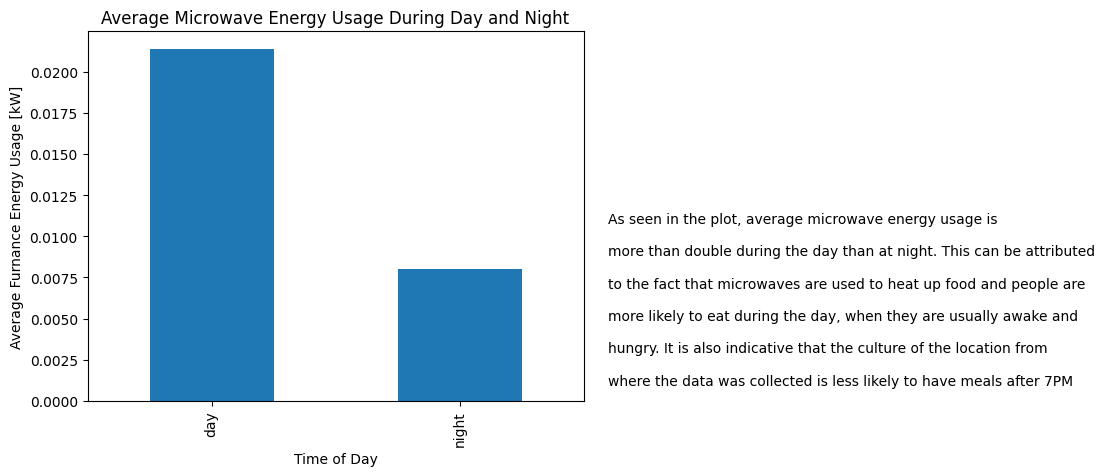

In [7]:
# plot a bar graph of average energy use of furnance during the day and night
# create a DataFrame with the energy usage of the furnance during the day and night
furnance_energy = energyData[['Date & Time', 'time', 'Microwave (R) [kW]']]
furnance_energy = furnance_energy.groupby(['time']).mean(numeric_only=True)
# create a bar graph of the energy usage of the furnance during the day and night
furnance_energy.plot(kind='bar', title='Average Microwave Energy Usage During Day and Night', legend=False)
plt.xlabel('Time of Day')
plt.ylabel('Average Furnance Energy Usage [kW]')
analysis = """As seen in the plot, average microwave energy usage is\n
more than double during the day than at night. This can be attributed\n
to the fact that microwaves are used to heat up food and people are\n
more likely to eat during the day, when they are usually awake and\n
hungry. It is also indicative that the culture of the location from\n
where the data was collected is less likely to have meals after 7PM
"""
plt.text(1.6, 0, analysis, rotation=0)
plt.show()